In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.llms import Ollama


def generate_insights(data_file="synthetic_math_data.csv", output_file="aggregated_insights.csv"):
    """
    Generate aggregated insights based on student performance data.
    """
    data = pd.read_csv(data_file)

    aggregated_data = data.groupby(['Category', 'Difficulty']).agg(
        avg_time=('TimeTaken', 'mean'),
        avg_attempts=('Attempts', 'mean'),
        success_rate=('Correctness', 'mean')
    ).reset_index()

    difficulty_order = ['Easy', 'Medium', 'Hard']
    aggregated_data['Difficulty'] = pd.Categorical(aggregated_data['Difficulty'], categories=difficulty_order, ordered=True)
    aggregated_data = aggregated_data.sort_values(by=['Category', 'Difficulty'])

    aggregated_data.to_csv(output_file, index=False)

    visualize_data(data, aggregated_data)

    print(f"Aggregated insights saved to {output_file}")

def visualize_data(raw_data, aggregated_data):
    """
    Generate intuitive visualizations for insights, including a radar plot.
    """
    success_pivot = aggregated_data.pivot(index="Category", columns="Difficulty", values="success_rate")
    plt.figure(figsize=(10, 6))
    sns.heatmap(success_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Success Rate'})
    plt.title("Success Rate by Category and Difficulty")
    plt.xlabel("Difficulty")
    plt.ylabel("Category")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=aggregated_data, x="Category", y="avg_time", hue="Difficulty", palette="viridis")
    plt.title("Average Time Taken by Category and Difficulty")
    plt.ylabel("Average Time (seconds)")
    plt.xlabel("Category")
    plt.legend(title="Difficulty")
    plt.show()

    user_data = raw_data.groupby('UserID').agg(
        avg_time=('TimeTaken', 'mean'),
        avg_attempts=('Attempts', 'mean'),
        success_rate=('Correctness', 'mean')
    ).reset_index()

    radar_data = user_data[['avg_time', 'avg_attempts', 'success_rate']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    radar_data['UserID'] = user_data['UserID']

    best_performer = radar_data.loc[radar_data['success_rate'].idxmax()]
    worst_performer = radar_data.loc[radar_data['success_rate'].idxmin()]

    categories = ['Avg Time', 'Avg Attempts', 'Success Rate']

    def plot_radar(data_row, label, color):
        radar_row = data_row[:-1].values.flatten()
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        radar_row = np.concatenate((radar_row, [radar_row[0]]))
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.fill(angles, radar_row, color=color, alpha=0.25)
        ax.plot(angles, radar_row, color=color, linewidth=2)
        ax.set_yticks(np.linspace(0, 1, 6))
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title(f"Performance Radar for {label} Performer", size=14, y=1.1)
        plt.show()

    plot_radar(best_performer, "Best", "green")
    plot_radar(worst_performer, "Worst", "red")

    print("Visualizations displayed.")



def generate_feedback(
    data_file="synthetic_math_data.csv",
    output_file="personalized_feedback.csv",
    sample_size=1
):
    """
    Generate personalized feedback for a sample of students using an LLM.
    """
    data = pd.read_csv(data_file)

    unique_users = data['UserID'].unique()[:sample_size]

    llm = Ollama(model="llama3.1")
    feedback_list = []

    for user_id in unique_users:
        user_data = data[data['UserID'] == user_id].to_dict('records')
        summary = f"User {user_id}: {len(user_data)} questions analyzed across categories {set(d['Category'] for d in user_data)}. Average time taken: {np.mean([d['TimeTaken'] for d in user_data]):.2f} seconds."
        prompt = f"Given this summary: {summary} and detailed metrics: {user_data}, generate personalized feedback and recommendations."
        response = llm(prompt)

        feedback_list.append({
            'UserID': user_id,
            'Summary': summary,
            'Feedback': response
        })

    feedback_df = pd.DataFrame(feedback_list)
    feedback_df.to_csv(output_file, index=False)

    print(f"Personalized feedback for {sample_size} students saved to {output_file}")


def solve_doubt_with_feedback_engine(
    doubt,
    user_id,
    data_file="synthetic_math_data.csv",
    feedback_file="personalized_feedback.csv",
    category="General",
    difficulty="Medium"
):
    """
    Solve doubts using personalized feedback and performance data.
    """
    data = pd.read_csv(data_file)
    feedback_data = pd.read_csv(feedback_file)

    user_feedback = feedback_data[feedback_data['UserID'] == user_id]
    if user_feedback.empty:
        print(f"No feedback found for UserID: {user_id}.")
        return

    summary = user_feedback.iloc[0]['Summary']
    feedback = user_feedback.iloc[0]['Feedback']

    llm = Ollama(model="mathstral")
    prompt = f"""
    The student has asked the following doubt in the '{category}' category at '{difficulty}' difficulty:
    "{doubt}"
    
    Student Summary:
    {summary}
    
    Personalized Feedback:
    {feedback}
    
    Based on the student's strengths, weaknesses, and performance trends, provide the following:
    1. A detailed step-by-step solution to the problem.
    2. A helpful hint to guide the student without revealing the full solution.
    3. Three additional practice problems of similar difficulty and category, aligned with the student's areas of improvement.
    """

    response = llm(prompt)

    return {
        "solution": response.get("solution", "Solution not provided"),
        "hint": response.get("hint", "Hint not provided"),
        "practice_problems": response.get("practice_problems", "Practice problems not provided")
    }


/home/mayank/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


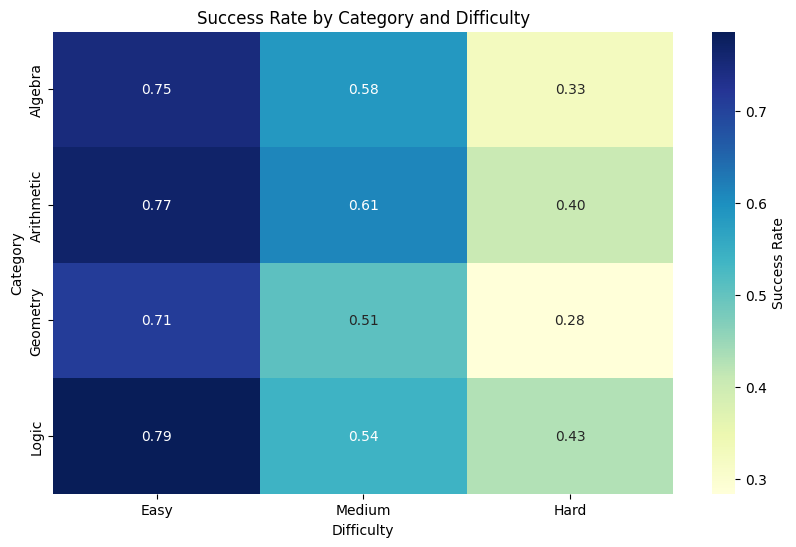

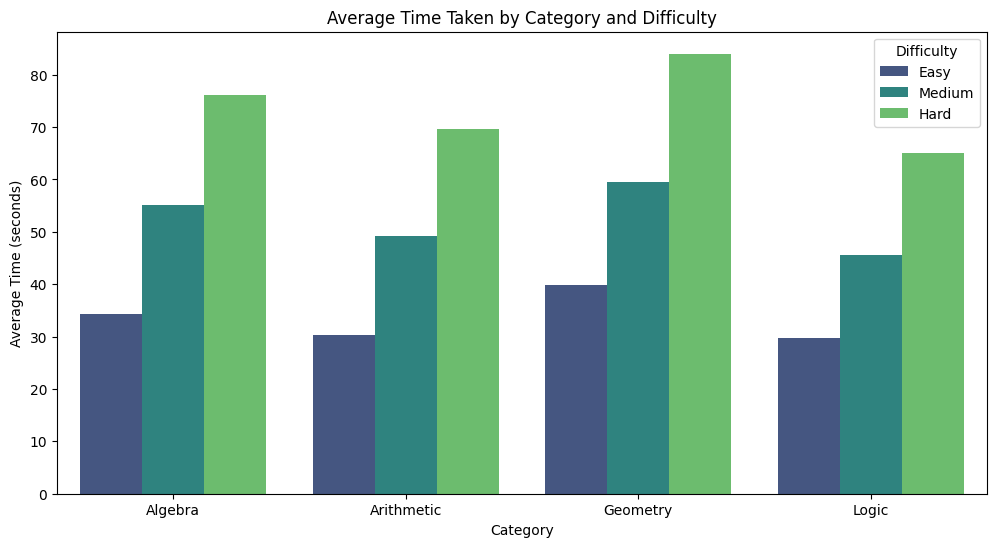

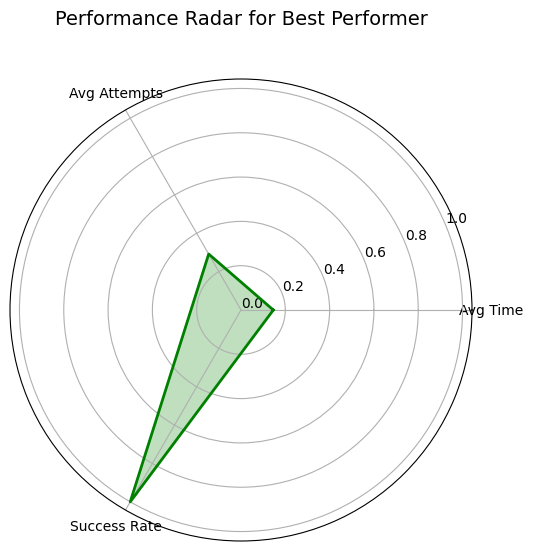

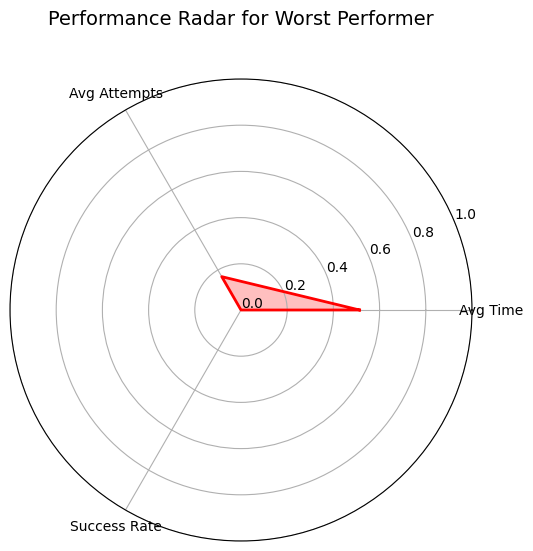

Visualizations displayed.
Aggregated insights saved to aggregated_insights.csv


In [2]:
generate_insights()

In [ ]:
generate_feedback()

/tmp/ipykernel_230500/4193152658.py:98: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.1")
/tmp/ipykernel_230500/4193152658.py:105: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


In [ ]:
doubt = "How do I calculate the area of a triangle with vertices at (0, 0), (4, 0), and (0, 3)?"
user_id = 101
result = solve_doubt_with_feedback_engine(
    doubt=doubt,
    user_id=user_id,
    category="Geometry",
    difficulty="Medium"
)
print("\nSolution:")
print(result["solution"])
print("\nHint:")
print(result["hint"])
print("\nPractice Problems:")
print(result["practice_problems"])